For this first task we need to load some standard libraries and Beautiful soup.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import urllib.request
import matplotlib.pyplot as plt

Now we will load the URL, the html that gets loaded after executing the javascript encoded in the webpage, that hosts the possible search fields and the respective options (obtained with the help of Postman).

In [2]:
myURL = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportmodel=133685247"
with urllib.request.urlopen(myURL) as url:
    s = url.read()
soup = BeautifulSoup(s,"html.parser")

Taking a quick look inside the html file in the web browser, it is clear that the select boxes contain the possible options and the equivalent html params encoded in fields called "options". We will load them into a data frame with the corresponding text that gets displayed to the user, and also with the field name that belongs to them.

In [3]:
options = soup.find_all("option")
fields = [f.text for f in soup.find_all("th")]
optionsDF = pd.DataFrame({'Value':[val["value"] for val in options],
                          'Tag':[val.text for val in options],
                          'Field':"NaN"})
i=0
for index, row in optionsDF.iterrows():
    if (row["Value"]=="null"):
        i=i+1
    row["Field"]=fields[i]
    
optionsDF = optionsDF[optionsDF.Value!="null"]
optionsDF.head()

,Field,Tag,Value
1,Unité académique,Architecture,942293
2,Unité académique,Chimie et génie chimique,246696
3,Unité académique,Cours de mathématiques spéciales,943282
4,Unité académique,EME (EPFL Middle East),637841336
5,Unité académique,Génie civil,942623


Now we can see that it is very easy to filter the search options of the webpage, for example:

In [4]:
optionsDF[optionsDF.Field=="Période académique"].head()

,Field,Tag,Value
21,Période académique,2016-2017,355925344
22,Période académique,2015-2016,213638028
23,Période académique,2014-2015,213637922
24,Période académique,2013-2014,213637754
25,Période académique,2012-2013,123456101


We can also check from Postman the ID's of the params in the URL (it could've been also made only with beautiful soup, but we are dealing with nested repeated tags, so it can't really be generalized), which are:

In [5]:
mParams = pd.DataFrame({'Value':["null"]},
                        index= ["ww_x_GPS", "ww_i_reportModel","ww_i_reportModelXsl",
                               "ww_x_UNITE_ACAD","ww_x_PERIODE_ACAD","ww_x_PERIODE_PEDAGO",
                               "ww_x_HIVERETE"])
#Load default values
mParams.Value[0]=-1
mParams.Value[1]=133685247
mParams.Value[2]=133685270
mParams

,Value
ww_x_GPS,-1
ww_i_reportModel,133685247
ww_i_reportModelXsl,133685270
ww_x_UNITE_ACAD,null
ww_x_PERIODE_ACAD,null
ww_x_PERIODE_PEDAGO,null
ww_x_HIVERETE,null


We can now set up specific URLS:

In [6]:
def getURL(optVect):
    baseURL = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?"
    pParams = mParams.copy()
    pParams.Value = [-1,133685247,133685270] + optVect
    for index,row in pParams.iterrows():
        baseURL = baseURL + row.name + "=" + str(row.Value) + "&"
    return baseURL[:-1]

def getValVector(id_u,id_pa,id_pp,id_h):
    return [optionsDF[optionsDF.Field=="Unité académique"].iloc[id_u].Value if id_u!=-1 else "null",
           optionsDF[optionsDF.Field=="Période académique"].iloc[id_pa].Value if id_pa!=-1 else "null",
           optionsDF[optionsDF.Field=="Période pédagogique"].iloc[id_pp].Value if id_pp!=-1 else "null",
           optionsDF[optionsDF.Field=="Type de semestre"].iloc[id_h].Value if id_h!=-1 else "null"]

def getFieldNames(id_u,id_pa,id_pp,id_h):
    return [optionsDF[optionsDF.Field=="Unité académique"].iloc[id_u].Tag if id_u!=-1 else "null",
           optionsDF[optionsDF.Field=="Période académique"].iloc[id_pa].Tag if id_pa!=-1 else "null",
           optionsDF[optionsDF.Field=="Période pédagogique"].iloc[id_pp].Tag if id_pp!=-1 else "null",
           optionsDF[optionsDF.Field=="Type de semestre"].iloc[id_h].Tag if id_h!=-1 else "null"]

The third function is just so we can check which fields are we requesting

In [7]:
getFieldNames(11,0,10,-1)

['Mathématiques', '2016-2017', 'Master semestre 3', 'null']

As an example, this is the url that we get for mathematics, period 2016-2017, Master Semester 3: 

In [8]:
getURL(getValVector(11,0,10,-1))

'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD=944590&ww_x_PERIODE_ACAD=355925344&ww_x_PERIODE_PEDAGO=2230128&ww_x_HIVERETE=null'

We can read the information from the URL to pass it to Beautiful Soup and start tryng to take out information from the html tables:

In [9]:
with urllib.request.urlopen(getURL(getValVector(11,0,10,-1))) as url:
    s = url.read()
aData = BeautifulSoup(s,"html.parser")

Let's start by taking the headers of the table, meaning the column names *and* the fields of study

In [10]:
header = [h.text for h in aData.find_all("th")]
header[:15]

['Ingénierie mathématique, 2016-2017, Master semestre 3\n\xa0(25 ét.)\n    ',
 'Civilité',
 'Nom Prénom',
 'Orientation Bachelor',
 'Orientation Master',
 'Spécialisation',
 'Filière opt.',
 'Mineur',
 'Statut',
 'Type Echange',
 'Ecole Echange',
 'No Sciper',
 'Mathématiques - master, 2016-2017, Master semestre 3\n\xa0(9 ét.)\n    ',
 'Civilité',
 'Nom Prénom']

And now we get the content of the table:

In [11]:
content = [h.text for h in aData.find_all("td")]
content[:15]

['Monsieur',
 'Arnould-Borel\xa0Charles Antoine André',
 '',
 '',
 '',
 '',
 'Mineur en Management, technologie et entrepreneuriat',
 'Présent',
 '',
 '',
 '215913',
 '',
 'Monsieur',
 'Bandelier\xa0Valentin Michel',
 '']

The goal is to pass this information to an equivalent data frame in pandas. For this, we will cheat a little bit: We can notice that the field that describes the area of study contains also the number of students inside and that they are located between parenthesis (we decode the byte string from the url in `latin_1` encoding format, as specified in the html header):

In [12]:
from IPython.core.display import HTML
HTML(s.decode("latin_1"))

We can extract this numbers from the line:

In [13]:
for row in header:
    if(row.find("(")!=-1):

        par = row[row.find("(")+1:row.find(")")]
        print([int(s) for s in par.split() if s.isdigit()][0])
        tok = row.split(',')
        tok[-1]=tok[-1].split('\n')[0]
        print(tok)

25
['Ingénierie mathématique', ' 2016-2017', ' Master semestre 3']
9
['Mathématiques - master', ' 2016-2017', ' Master semestre 3']
0
["Mathématiques pour l'enseignement", ' 2016-2017', ' Master semestre 3']
24
['Science et ingénierie computationnelles', ' 2016-2017', ' Master semestre 3']


Now we use this information to turn the table into a usefull dataframe:

In [14]:
#Retrieve column names in the table, that we've seen they are between the names of their studies.
#ATTENTION: THE URL MUST NOT LEAD TO AN EMPTY TABLE OR A TABLE STARTING WITH 0 STUDENTS
gotNames = False
nFields=0
for idx,row in enumerate(header):
    if(row.find("(")!=-1):
        if not gotNames:
            gotNames=True
        else:
            nFields=idx-1
            break
            
        par = row[row.find("(")+1:row.find(")")]
        [int(s) for s in par.split() if s.isdigit()][0]
        
colNames = header[1:idx]

data=pd.DataFrame(columns=colNames)

counter = 0;
nmbEt=0;
for row in header:
    if(row.find("(")!=-1):
        par = row[row.find("(")+1:row.find(")")]
        nmbEt=[int(s) for s in par.split() if s.isdigit()][0]
        for i in range(0,nmbEt):
            data.loc[counter] = content[counter*(nFields)+counter:(counter+1)*(nFields)+counter]
            counter = counter+1;
    
data

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper
0,Monsieur,Arnould-Borel Charles Antoine André,,,,,"Mineur en Management, technologie et entrepren...",Présent,,,215913
1,Monsieur,Bandelier Valentin Michel,,,,,,Stage,,,189515
2,Monsieur,Bays Xavier,,,,,,Présent,,,224854
3,Madame,Biletta Anna-Maria,,,,,,Présent,,,260145
4,Monsieur,Brunat Grégoire Pierre-Olivier,,,,,,Présent,,,201023
5,Monsieur,De Castro Fernandes Adrien Jorge Roger,,,,,,Stage,,,203940
6,Madame,Favre Julie Marthe,,,,,,Stage,,,226481
7,Madame,Ghita Lavinia,,Statistique et probabilités appliquées,,,,Stage,,,224570
8,Monsieur,Jauslin Raphaël,,,,,,Présent,,,217432
9,Monsieur,Kianmanesh Rad Melvin,,Statistique et probabilités appliquées,,,,Stage,,,227951


(-1.0024502532770365,
 1.0000000204621207,
 -1.0033997626005469,
 1.0013169298062889)

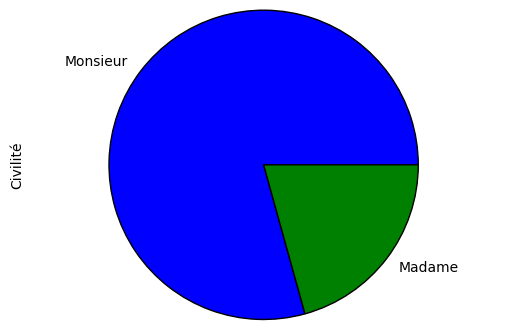

In [15]:
data.Civilité.value_counts().plot(kind='pie')
plt.axis('equal')

Just for consistency, let's wrap all this in a single function, and let's make a little modification. The names are not a reliable index as we know, because they might repeat. However, the last column (sciper number) is a unique identifier, thing we can check with the "isunique" function. So let's make the sciper the ID. Let's also add three columns: "Études, Période, Semestre":

In [16]:
def loadColumns():
    gotNames = False
    nFields=0
    st=0
    for idx,row in enumerate(header):
        if(row.find("(")!=-1):
            if not gotNames:
                gotNames=True
            else:
                nFields=idx-1
                break

            par = row[row.find("(")+1:row.find(")")]
            [int(s) for s in par.split() if s.isdigit()][0]
    

def urlToDataFrame(urlString):
    with urllib.request.urlopen(urlString) as url:
        s = url.read()
    aData = BeautifulSoup(s,"html.parser")
    header = [h.text for h in aData.find_all("th")]
    header[:15]
    content = [h.text for h in aData.find_all("td")]
    content[:15]

    colNames = header[1:12]

    data=pd.DataFrame(columns=colNames+["Études","Période","Semestre"])

    counter = 0;
    nmbEt=0;
    for row in header:
        if(row.find("(")!=-1):
            par = row[row.find("(")+1:row.find(")")]
            nmbEt=[int(s) for s in par.split() if s.isdigit()][0]
            tok = row.split(',')
            tok[-1]=tok[-1].split('\n')[0]
            for i in range(0,nmbEt):
                data.loc[counter] = content[counter*(nFields)+counter:(counter+1)*(nFields)+counter] + tok
                counter = counter+1;
    return data

Now let's put in a single data frame the data of the students in Informatique starting from 2007.

In [17]:
#['Informatique', 'null', 'null', 'null']
fData = urlToDataFrame(getURL(getValVector(8,0,-1,-1)))
fData = pd.concat([fData,urlToDataFrame(getURL(getValVector(8,1,-1,-1)))])
fData = pd.concat([fData,urlToDataFrame(getURL(getValVector(8,2,-1,-1)))])
fData = pd.concat([fData,urlToDataFrame(getURL(getValVector(8,3,-1,-1)))])
fData = pd.concat([fData,urlToDataFrame(getURL(getValVector(8,4,-1,-1)))])
fData = pd.concat([fData,urlToDataFrame(getURL(getValVector(8,5,-1,-1)))])
fData = pd.concat([fData,urlToDataFrame(getURL(getValVector(8,6,-1,-1)))])
fData = pd.concat([fData,urlToDataFrame(getURL(getValVector(8,7,-1,-1)))])
fData = pd.concat([fData,urlToDataFrame(getURL(getValVector(8,8,-1,-1)))])
fData = pd.concat([fData,urlToDataFrame(getURL(getValVector(8,9,-1,-1)))])

In [18]:
#fData[["José" in rs for rs in fData['Nom Prénom']]].head()
fData.head()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Études,Période,Semestre
0,Monsieur,Aspelin Karl Oskar,,,,,,Présent,Erasmus,Aalto University,272925,Echange IN,2016-2017,Semestre automne
1,Monsieur,Aurlien Kristian,,,,,,Présent,Erasmus,Norwegian University of Science and Technology...,272175,Echange IN,2016-2017,Semestre automne
2,Monsieur,Baptista Águas André,,,,,,Présent,Erasmus,Universidade de Lisboa,272043,Echange IN,2016-2017,Semestre automne
3,Monsieur,Bernardi Michael,,,,,,Présent,Bilatéral,"University of New South Wales, Sydney",273845,Echange IN,2016-2017,Semestre automne
4,Monsieur,Böhm Felix,,,,,,Présent,Erasmus,Technische Universität Berlin,276596,Echange IN,2016-2017,Semestre automne


In [21]:
lastData = fData.copy()
lastData = lastData[lastData.Études=="Informatique"]
lastData.index = lastData['No Sciper']
lastData = lastData[[("Bachelor semestre 1" in per) or ("Bachelor semestre 6" in per) for per in lastData['Semestre']]]
lastData = lastData.drop(["Orientation Bachelor", "Orientation Master", "Spécialisation", "Filière opt.",
              "Mineur", "Ecole Echange", "Type Echange", "Études", "No Sciper"],1)
lastData.head()

,Civilité,Nom Prénom,Statut,Période,Semestre
No Sciper,,,,,
235688,Monsieur,Abbey Alexandre,Présent,2016-2017,Bachelor semestre 1
274015,Monsieur,Ahn Seongho,Présent,2016-2017,Bachelor semestre 1
268410,Madame,Alemanno Sara,Présent,2016-2017,Bachelor semestre 1
271464,Monsieur,Althaus Luca,Présent,2016-2017,Bachelor semestre 1
274518,Monsieur,Assi Karim,Présent,2016-2017,Bachelor semestre 1


In [22]:
scipers = lastData.index.unique()
corr = 0
for sciper in scipers:
    Finished = (True in ["6" in student for student in lastData.loc[sciper].Semestre])
    Started = (True in ["1" in student for student in lastData.loc[sciper].Semestre])
    
    if not Finished or not Started:
        lastData = lastData.drop(sciper,0)
        corr = corr +1

In [23]:
scipers = lastData.index.get_values()

In [24]:
scipers = lastData.index.get_values()
time=0
for sciper in scipers:
    par = lastData.loc[sciper].tail(1).Période
    par = par.get_values()[0].split('-')
    inY = [int(s) for s in par[0].split() if s.isdigit()][0]
    par = lastData.loc[sciper].head(1).Période
    par = par.get_values()[0].split('-')
    outY = par[1]
    time = time + int(outY)-int(inY)
time/len(scipers)

3.6738683127572016

Now let's re do the calculation but separating in females and males

In [25]:
femData = lastData[lastData.Civilité == "Madame"]
maleData = lastData[lastData.Civilité == "Monsieur"]

scipers = maleData.index.get_values()
time=0
for sciper in scipers:
    par = maleData.loc[sciper].tail(1).Période
    par = par.get_values()[0].split('-')
    inY = [int(s) for s in par[0].split() if s.isdigit()][0]
    par = maleData.loc[sciper].head(1).Période
    par = par.get_values()[0].split('-')
    outY = par[1]
    time = time + int(outY)-int(inY)

res = pd.DataFrame({'Average (years)':[0.0,0.0]},
                  index = ["Madame","Monsieur"])

res.loc["Monsieur"] = time/len(scipers)

scipers = femData.index.get_values()
time=0
for sciper in scipers:
    par = femData.loc[sciper].tail(1).Période
    par = par.get_values()[0].split('-')
    inY = [int(s) for s in par[0].split() if s.isdigit()][0]
    par = femData.loc[sciper].head(1).Période
    par = par.get_values()[0].split('-')
    outY = par[1]
    time = time + int(outY)-int(inY)
time/len(scipers)

res.loc["Madame"]= time/len(scipers)

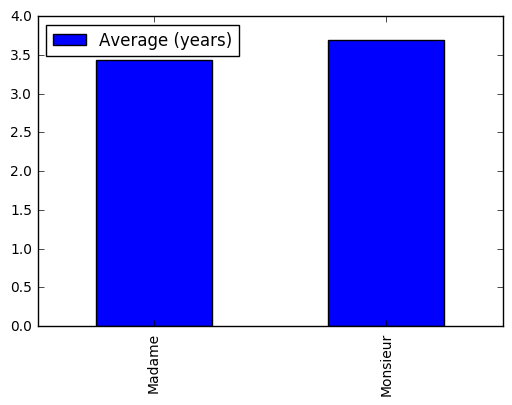

In [26]:
res.plot(kind='bar')